In [22]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [23]:
with h5py.File('0B11619_10x.hdf5', 'a') as hdf5_file:
    original_images = hdf5_file['images']

    print(original_images[0].shape)

(21, 21, 2)


In [2]:
def inspect_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as file:
        print("Inspecting:", file_path)
        def print_structure(name, obj):
            print(name, "Type:", type(obj))
            if isinstance(obj, h5py.Dataset):
                print(" - Shape:", obj.shape, " - Dtype:", obj.dtype)
        file.visititems(print_structure)


# set parameters
torch.manual_seed(0)
file_path = '0ADD710_full.hdf5'
inspect_hdf5_file(file_path)

# inspect_hdf5_file(file_path='0B11619_10x.hdf5')

data_split = (0.7, 0.15, 0.15)
batch_size = 256
learning_rate = 0.001
weight_decay = 1e-5
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Inspecting: 0ADD710_full.hdf5
channels Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (4,)  - Dtype: object
features Type: <class 'h5py._hl.group.Group'>
features/axis0 Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (77,)  - Dtype: |S19
features/axis1 Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (5928,)  - Dtype: int64
features/block0_items Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (71,)  - Dtype: |S19
features/block0_values Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (5928, 71)  - Dtype: float64
features/block1_items Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (6,)  - Dtype: |S11
features/block1_values Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (5928, 6)  - Dtype: int64
images Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (5928, 45, 45, 4)  - Dtype: uint16
targets Type: <class 'h5py._hl.dataset.Dataset'>
 - Shape: (5928,)  - Dtype: float64
Selected device: cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


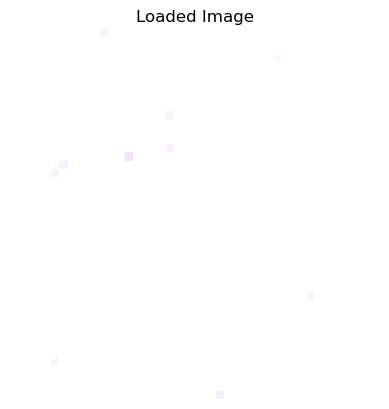

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = '0ADD710_full.hdf5'
dataset_name = 'images'

with h5py.File(file_path, 'r') as hdf:
    image = np.array(hdf[dataset_name][1])

# Display the image
plt.imshow(image, cmap='grey')  # Use cmap='gray' for grayscale images
plt.title('Loaded Image')
plt.axis('off')
plt.show()

In [4]:
import numpy as np

def crop_center(img, cropx, cropy):
    """
    Crops an image to a desired size around its center.

    Parameters:
    - img: NumPy array of shape (H, W) or (H, W, C), where
        H is the height, W is the width, and C is the number of channels.
    - cropx: Integer, desired width of the cropped image.
    - cropy: Integer, desired height of the cropped image.

    Returns:
    - Cropped image as a NumPy array.
    """
    y, x = img.shape[:2]  # Get the size of the image
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    if img.ndim == 2:  # Grayscale image
        return img[starty:starty+cropy, startx:startx+cropx]
    else:  # Color image
        return img[starty:starty+cropy, startx:startx+cropx, :]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


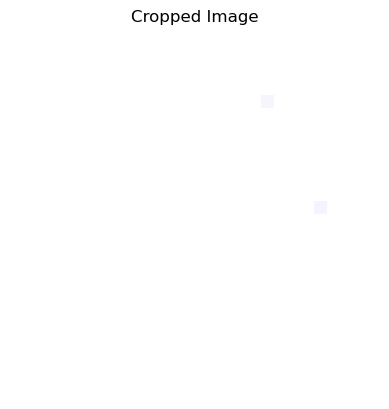

In [5]:
import h5py
import matplotlib.pyplot as plt

file_path = '0ADD710_full.hdf5'
dataset_name = 'images'

# Desired size of the cropped image
crop_width = 100
crop_height = 100

# Load the image
with h5py.File(file_path, 'r') as hdf:
    # Assuming you're loading the first image for simplicity
    image = np.array(hdf[dataset_name][0])

# Crop the image around the center
cropped_image = crop_center(image, crop_width, crop_height)

# Display the cropped image
plt.imshow(cropped_image, cmap='gray')  # Use appropriate colormap (cmap)
plt.title('Cropped Image')
plt.axis('off')
plt.show()


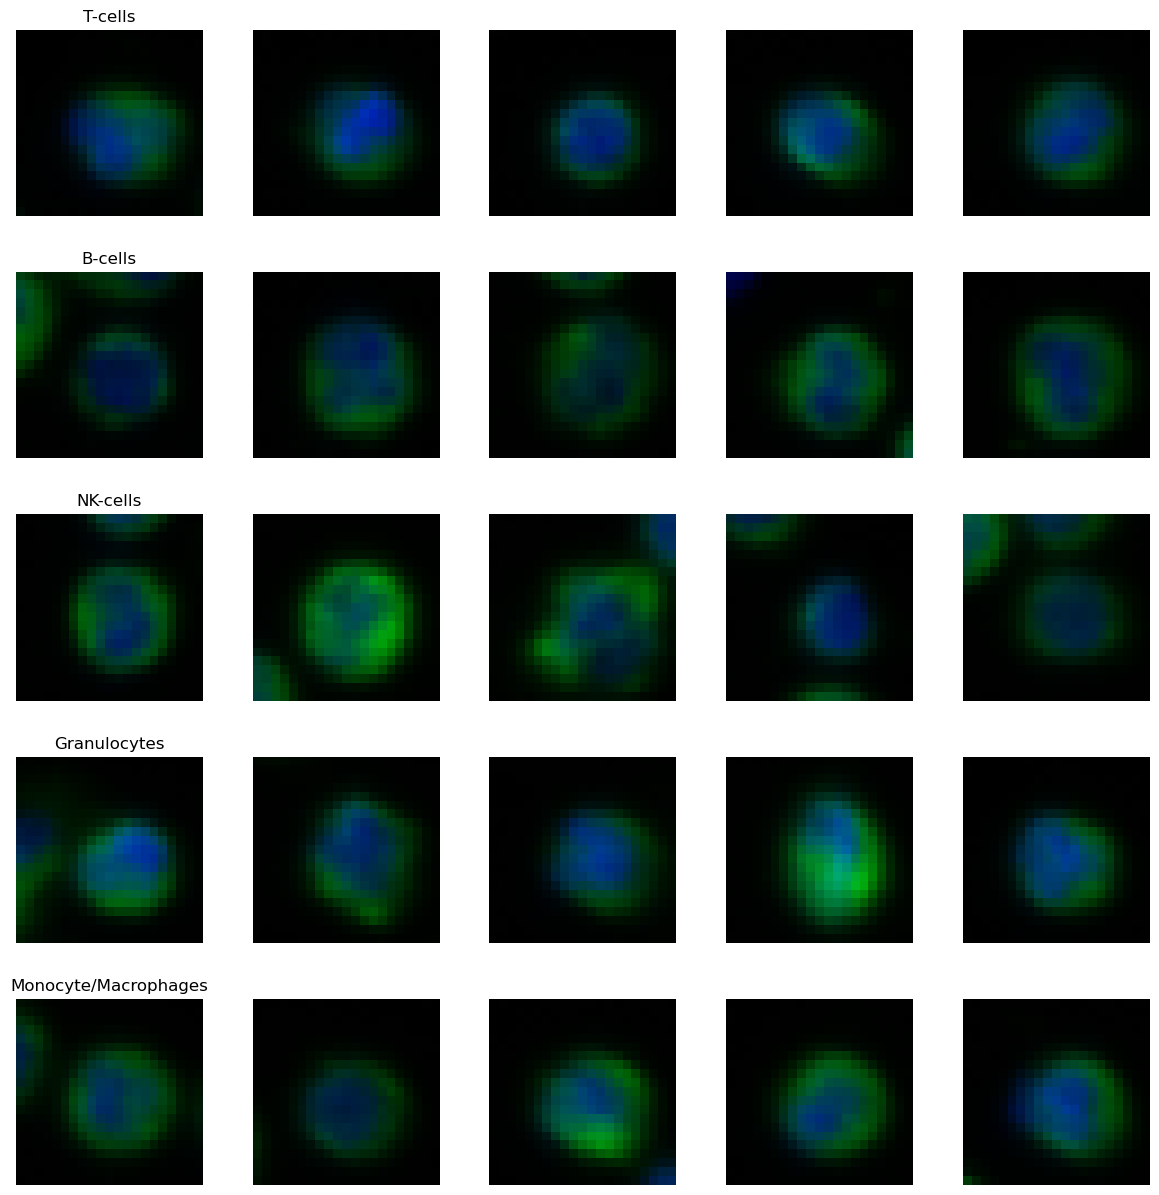

In [42]:

def display_images_by_class(images, classifications, class_names, ):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, len(class_names) * 3))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for row, class_name in enumerate(class_names):
        indices = [i for i, x in enumerate(classifications) if x == class_name]
        selected_images = [images[i] for i in indices[20:25]]  # Display up to 5 images per class
        
        for col, img in enumerate(selected_images):
            # rgb_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

            scaler = 65535.0
            zero_image = np.zeros_like(img[...,0])
            rgb_image = np.stack([zero_image / scaler, img[...,2] / scaler, img[...,0] / scaler], axis=2)
            
            # Display the image
            axes[row, col].imshow(rgb_image)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_title(f"{class_name}")
                
    plt.show()




# def display_images_by_class(images, classifications, class_names):
#     fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, len(class_names) * 3))
#     fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
#     for row, class_name in enumerate(class_names):
#         indices = [i for i, x in enumerate(classifications) if x == class_name]
#         selected_images = [images[i] for i in indices[:5]]  # Display up to 5 images per class
        
#         for col, img in enumerate(selected_images):
            
#             axes[row, col].imshow(img[..., 0], cmap='gray')

#             axes[row, col].axis('off')
#             if col == 0:
#                 axes[row, col].set_title(f"{class_name}")
                
#     plt.show()


# Load classifications
labels_df = pd.read_csv('0ADD710_gated_full.txt', sep='\t')
# Assuming you have a column 'Multiclass_5' for 5-class classification
classifications = labels_df['Multiclass_5'].values

# Open HDF5 file to load images
file_path = '0ADD710_full.hdf5'
with h5py.File(file_path, 'r') as hdf:
    images = hdf['filtered_images'][:]  # Load all images; adjust if only a subset is needed

class_names = ['T-cells', 'B-cells', 'NK-cells', 'Granulocytes', 'Monocyte/Macrophages']
display_images_by_class(images, classifications, class_names)


In [ ]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_images_and_labels(hdf5_path, images_output_folder, labels_csv_path):
    # Ensure the images output folder exists
    os.makedirs(images_output_folder, exist_ok=True)
    
    with h5py.File(hdf5_path, 'r') as hdf:
        # Load images and labels from the HDF5 file
        images = np.array(hdf['filtered_images'])
        labels = np.array(hdf['targets'])
        
        # Initialize an empty list to store label information
        labels_list = []

        # Process each image and corresponding label
        for idx, (image, label) in enumerate(zip(images, labels)):
            # Save each image to disk
            image_path = os.path.join(images_output_folder, f'image_{idx}.png')
            plt.imsave(image_path, image)
            
            # Append label information including the image index
            labels_list.append({'Index': idx, 'Label': label})
            
            print(f'Saved image {idx} to {image_path}')

        # Create a DataFrame from the labels list
        labels_df = pd.DataFrame(labels_list)
        
        # Save the DataFrame to a CSV file, maintaining the index
        labels_df.to_csv(labels_csv_path, index=False)
        print(f'Saved labels to {labels_csv_path}')

# Specify paths
hdf5_path = '0ADD710_full.hdf5'
images_output_folder = '0ADD710_binary_classification_images'
labels_csv_path = 'labels.csv'

extract_images_and_labels(hdf5_path, images_output_folder, labels_csv_path)


In [43]:
import h5py

def list_all_keys(hdf_file, group='/', indent=0):
    """
    Recursively lists all keys in an HDF5 file.

    :param hdf_file: An open HDF5 file object or a path to an HDF5 file.
    :param group: The current group to inspect. Defaults to the root group.
    :param indent: The indentation level for pretty printing. Defaults to 0.
    """
    # Open the file if a path is provided
    if isinstance(hdf_file, str):
        with h5py.File(hdf_file, 'r') as f:
            list_all_keys(f, group, indent)
        return

    # Otherwise, assume hdf_file is an already open HDF5 file object
    try:
        # Attempt to get the group from the file
        grp = hdf_file[group]
    except KeyError as e:
        print(f"Group {group} not found in the file.")
        return

    # Iterate over items in the current group
    for key, item in grp.items():
        print('  ' * indent + key)
        # If the item is a group, recurse into it
        if isinstance(item, h5py.Group):
            list_all_keys(hdf_file, item.name, indent + 1)

hdf5_path = '0B11619_10x.hdf5'
with h5py.File(hdf5_path, 'r') as hdf:
    list_all_keys(hdf)


channels
features
  axis0
  axis1
  block0_items
  block0_values
  block1_items
  block1_values
images
targets


In [47]:
with h5py.File('0B11619_10x.hdf5', 'r') as hdf:
    if 'features' in hdf.keys():
        # Assuming 'block0_items' or 'block1_items' contains column names
        block_items = hdf['features/block0_items'][:]  # Adjust as necessary
        print(block_items)
        print()
        block_items = hdf['features/block1_items'][:]
        print(block_items)


[b'y' b'x' b'CD45' b'CD20_SP32' b'CD27' b'CD117' b'CD20_H1'
 b'CD138_Syndecan' b'CD56' b'BCMA_2_clones' b'CD123' b'CD38' b'CD28'
 b'CD223_LAG3' b'CD14' b'CD62L' b'CD11c' b'CD69' b'CD8a'
 b'CD294_and_CXCR3' b'CD127' b'PD.1' b'CD45RA' b'CCR7' b'CD161'
 b'CD66b_CEACAM' b'CD3' b'CD25_IL2' b'CD45_RO' b'HLA_DR' b'CCR4_CD194'
 b'CD4' b'DNA1' b'DNA2' b'CD16']

[b'image_id' b'frame_id' b'Area' b'target']


In [46]:
import h5py
import numpy as np
import pandas as pd

# Define the path to the output TXT file
output_txt_path = 'cell_markers_and_labels.txt'

# Open the HDF5 file and read the marker values and any available labels
with h5py.File('0B11619_10x.hdf5', 'r') as hdf:
    # Check if the required datasets exist
    if 'features/block0_items' in hdf.keys() and 'features/block0_values' in hdf.keys():
        # Extract column names
        column_names = [name.decode('utf-8') for name in hdf['features/block0_items'][:]]
        print(f"Column names: {column_names}")
        
        # Extract the values
        values = hdf['features/block0_values'][:]
        
        # Create a DataFrame
        df = pd.DataFrame(values, columns=column_names)
        print(df.head())
        
        # If labels are in a separate dataset, extract them
        if 'targets' in hdf.keys():
            labels = hdf['targets'][:]
            df['Label'] = labels
            print(f"Data with labels:\n{df.head()}")
    
    # Save the DataFrame to a TXT file
    df.to_csv(output_txt_path, sep='\t', index=False)
    print(f"Data saved to {output_txt_path}")


Column names: ['y', 'x', 'CD45', 'CD20_SP32', 'CD27', 'CD117', 'CD20_H1', 'CD138_Syndecan', 'CD56', 'BCMA_2_clones', 'CD123', 'CD38', 'CD28', 'CD223_LAG3', 'CD14', 'CD62L', 'CD11c', 'CD69', 'CD8a', 'CD294_and_CXCR3', 'CD127', 'PD.1', 'CD45RA', 'CCR7', 'CD161', 'CD66b_CEACAM', 'CD3', 'CD25_IL2', 'CD45_RO', 'HLA_DR', 'CCR4_CD194', 'CD4', 'DNA1', 'DNA2', 'CD16']
            y           x      CD45  CD20_SP32      CD27     CD117   CD20_H1  \
0  779.973684  445.500000  3.904110   0.109589  0.054795  0.027397  0.041096   
1  772.472973  343.716216  1.819820   0.108108  0.054054  0.099099  0.063063   
2  769.626374  576.296703  3.633333   0.050000  0.150000  0.083333  0.033333   
3  769.773585  252.745283  3.200000   0.114286  0.100000  0.057143  0.085714   
4  762.645161  450.301075  3.821918   0.095890  0.205479  0.082192  0.041096   

   CD138_Syndecan      CD56  BCMA_2_clones  ...  CD66b_CEACAM       CD3  \
0        0.027397  0.068493       0.054795  ...      0.150685  1.219178   
1      

In [57]:
# Load gated cell file
labels_df = pd.read_csv('0B11619_gated_full.txt', sep='\t')
print(labels_df.shape)
# Filter out 'none' values
filtered_labels_df = labels_df[labels_df['Binary_classification'] != 'none']
print(filtered_labels_df.shape)
# Convert string labels to integers
labels_int = filtered_labels_df['Binary_classification'].map({'Lymphocytes': 1, 'Myelocytes': 0}).values
print(labels_int.shape)

# Add the 'new_label' column with labels_int values
filtered_labels_df['new_label'] = labels_int

# Now save the updated DataFrame back to a TXT file
filtered_labels_df.to_csv('0B11619_gated_full_updated.txt', sep='\t', index=False)

print("Updated DataFrame saved to '0B11619_gated_full_updated.txt'.")

(1344, 46)
(1344, 46)
(1344,)
Updated DataFrame saved to '0B11619_gated_full_updated.txt'.


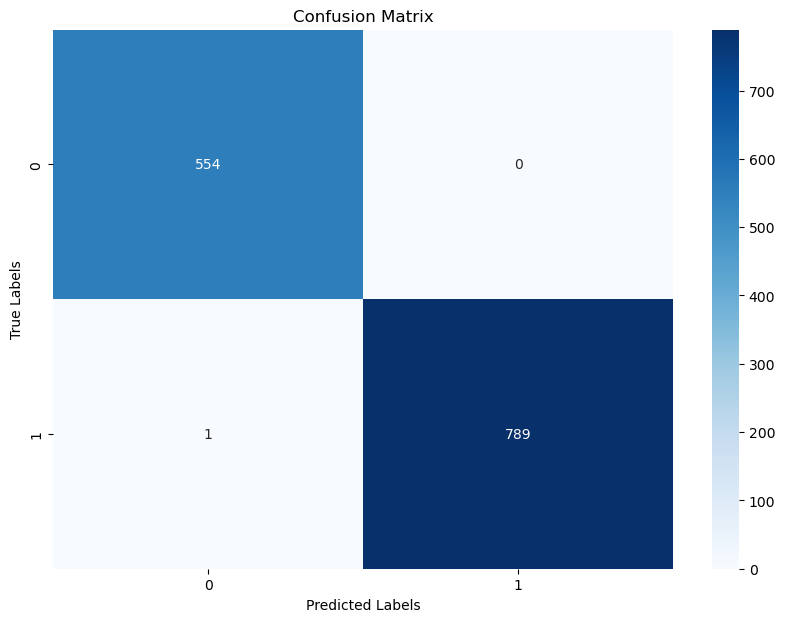

Mismatch rate: 0.07%


In [58]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('0B11619_gated_full_updated.txt', sep='\t')

# Ensure that both 'Label' and 'new_label' columns exist
if 'Label' in df.columns and 'new_label' in df.columns:
    # Compute the confusion matrix
    cm = confusion_matrix(df['Label'], df['new_label'])
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=set(df['new_label']), yticklabels=set(df['Label']))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate the mismatch rate
    total_instances = cm.sum()
    correct_predictions = np.trace(cm)
    mismatch_rate = (total_instances - correct_predictions) / total_instances
    print(f"Mismatch rate: {mismatch_rate:.2%}")

else:
    print("One or both of the required columns are missing.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

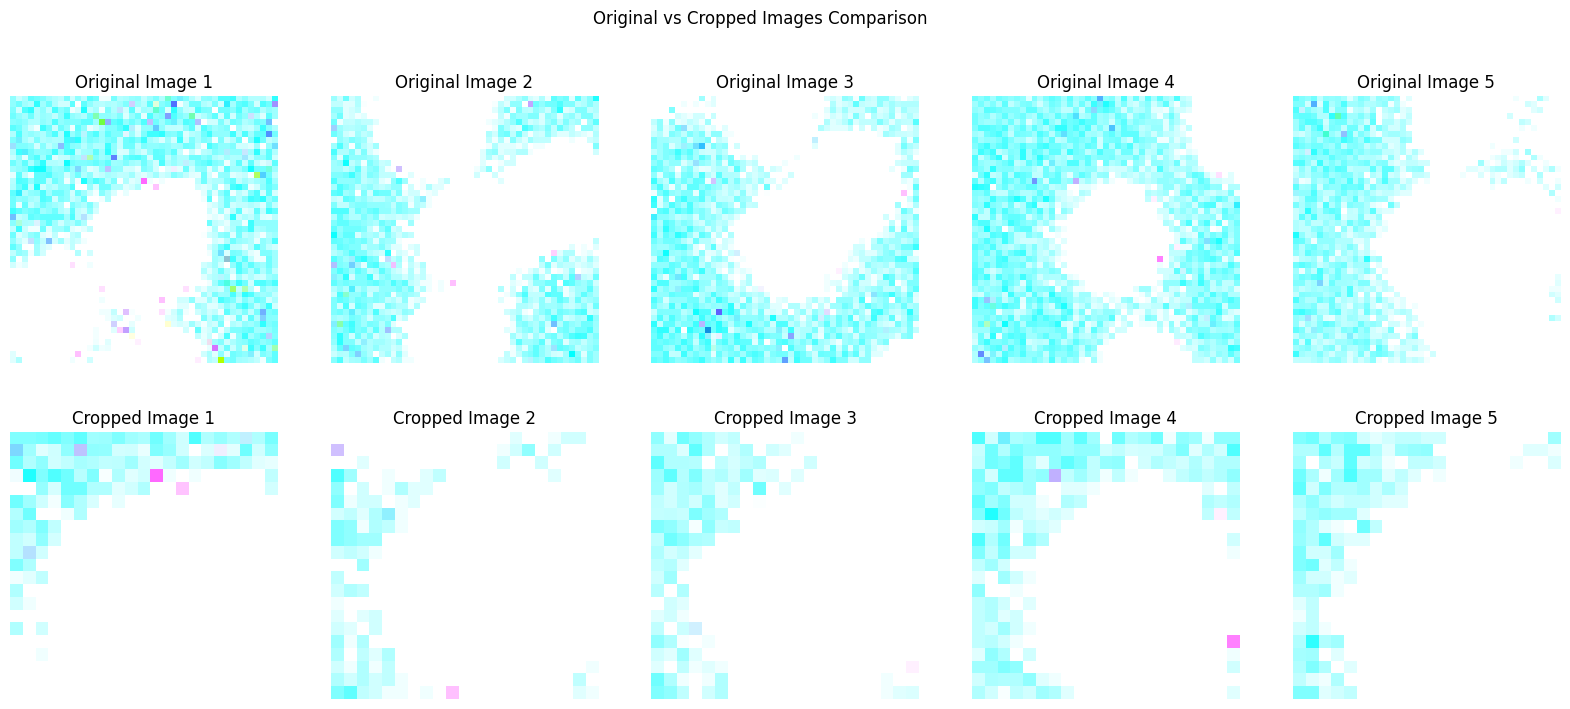

In [1]:
import h5py
import matplotlib.pyplot as plt


# Open the HDF5 file
with h5py.File('0ADD705_gated_full_copy.hdf5', 'r') as hdf5_file:
    # Load the first 5 images from both datasets
    original_images = hdf5_file['images'][:5]
    cropped_images = hdf5_file['cropped_images'][:5]

    # Assuming images are grayscale, if they have multiple channels, adjust the indexing accordingly
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Original vs Cropped Images Comparison')

    for i in range(5):
        # Display original images
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[0, i].set_title(f'Original Image {i+1}')
        axs[0, i].axis('off')

        # Display cropped images
        axs[1, i].imshow(cropped_images[i], cmap='gray')
        axs[1, i].set_title(f'Cropped Image {i+1}')
        axs[1, i].axis('off')

plt.show()
